<a href="https://colab.research.google.com/github/gabrielfas/Spotify-Playlist-Analysis/blob/master/Spotify_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spotipy

  Running setup.py bdist_wheel for spotipy ... - done
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [2]:
!pip install python-dotenv

In [0]:
"""
    This module makes the connection to the spotify WEB API to get information
    on the user music preferences. It is able to write csv files for playlists
    to be analyzed with future modules.
    The goal with this module is to make the spotify data available in a simple
    way for local analysis and interactive analysis with ipython or a jupyter
    notebook.
    This is an experimental project so the preferences are being saved in csv
    files but the music data should be saved in a database or not saved at
    all for privacy reasons.
    --- IMPORTANT ---
    All spotify objects in this module are dicts representing JSON objects defined
    in the Spotify WEB API @link: https://developer.spotify.com/web-api/object-model/
"""

import spotipy
import spotipy.util as util
import numpy as np
import sys, csv, os
import argparse
from dotenv import load_dotenv

In [0]:
load_dotenv()

_client_id = os.getenv("DIVERSIFY_CLIENT_ID")
_client_secret = os.getenv("DIVERSIFY_CLIENT_SECRET")
_redirect_uri = 'http://localhost/'

_scope = ['user-library-read', 'playlist-modify-private']
_fields = ['id', 'speechiness', 'valence', 'mode', 'liveness', 'key', 'danceability', 'loudness', 'acousticness',
           'instrumentalness', 'energy', 'tempo']

_limit = 50

In [0]:
def login_user(username, scope=None):
    """
    Logs the user to the Spotify WEB API with permissions declared in scope.
    Default permissions are 'user-library-read' and 'playlist-modify-private'.
    The return object is necessary to make further spotify queries, so this
    should be the first method to be called when using this module.
    :param username: Username to login
    :param scope: Array with permission strings
    :return: spotipy.Spotify object with user session
    """
    if scope is None:
        scope = _scope

    # TODO check if empty scope array will break the api call
    token = util.prompt_for_user_token(username, ' '.join(scope), client_id=_client_id, client_secret=_client_secret,
                                       redirect_uri=_redirect_uri)
    if token:
        return spotipy.Spotify(auth=token)
    else:
        print("Not able to get token for:", username)

In [0]:
def get_favorite_songs(spfy, features=False):
    """
    Queries the spotify WEB API for the logged user's saved musics.
    The token used to log in needs to have the 'user-library-read' permission.
    If that's not the case add it in the interfacespfy.scope array and refresh
    the token.
    Quantity of requests per call = ceil( n° of saved songs / limit )
    :param spfy: spfy object received when logging user
    :param limit: maximum of musics that will be returned from query
    :param features: False -> returns name and id, True -> returns id and features of the song
    :param genres: If it's true, makes another request to the API to get music genre info
    :return: list of dictionaries with name and id keys
    """

    local_limit = 50

    fields = ['name', 'id', 'popularity', 'duration_ms']
    results = spfy.current_user_saved_tracks(local_limit)

    def _get_song_info(json_response):
        result = []
        for item in json_response['items']:
            song = {field: item['track'][field] for field in fields}

            song['album'] = item['track']['album']['name']
            song['album_id'] = item['track']['album']['id']
            song['artist'] = item['track']['artists'][0]['name']
            song['artist_id'] = item['track']['artists'][0]['id']

            result.append(song)
        return result

    songs = _for_all(results, _get_song_info, spfy)

    if features:
        return get_features(spfy, songs)
    else:
        return songs

In [0]:
def get_user_playlists(spfy, userid, features=False, flat=False):
    """
    Queries the spotify WEB API for the musics in the public playlists
    from the user with the userid (Spotify ID).
    The limit is the number of songs per playlists that will be returned.
    The return is a list of playlists with each being represented by a
    tuple of (name, list of songs (each being a dict with song info)).
    :param spfy: Spotipy session object that is returned when logging user
    :param userid:  The Spotify ID of the playlits' owner
    :param features: If true, gets features instead of song data. default: False
    :return: A list of lists representing songs in each public playlists.
    """

    local_limit = 50

    playlist_query = spfy.user_playlists(userid, local_limit)     # Returns a Spotify object (paging object) with playlists

    # TODO try to change this method to _get_song_info
    def _get_tracks_from_playlist(tracks_paging):
        tracks = []
        for item in tracks_paging['items']:
            track = {field: item['track'][field] for field in ['name', 'id', 'popularity', 'duration_ms']}
            tracks.append(track)
        return tracks

    def _get_all_playlists(playlist_paging):
        result = []
        for playlist in playlist_paging['items']:
            if playlist['owner']['id'] == userid:
                response = spfy.user_playlist(userid, playlist['id'], fields="tracks,next")   # return a playlist object
                trackspo = response['tracks']             # Array with information about the tracks in the playlist
                tracks = _for_all(trackspo, _get_tracks_from_playlist, spfy)
                result.append((playlist['name'], tracks, ))
        return result

    playlists = _for_all(playlist_query, _get_all_playlists, spfy)

    if features:
        result = []
        for name, playlist in playlists:
            result.extend(get_features(spfy, playlist))
        return result
    else:
        return playlists

In [0]:
def get_new_songs(spfy, seed_tracks, country=None, features=False):

    local_limit = 100
    trackids = [track['id'] for track in seed_tracks]
    fids = np.random.choice(trackids, 5)
    result = spfy.recommendations(seed_tracks=fids.tolist(), limit=local_limit, country=country)
    songs = [{field: track[field] for field in ['id', 'name', 'duration_ms', 'popularity']} for track in result['tracks']]

    if features:
        return get_features(spfy, songs)
    else:
        return songs

In [0]:
def show_tracks(tracks):
    """
    Show tracks from a Spotify object (Paging object) that contains an array of
    dictionaries (JSON objects) representing tracks.
    :param tracks: Spotify paging object
    :return: None
    """
    for idx, item in enumerate(tracks['items']):
        track = item['track']
        print("{0} {1:32.32s} {2:32s}".format(idx, track['artists'][0]['name'], track['name']))


In [0]:
def user_playlists_to_csv(spfy, userid, filename=None):
    """
    Writes a csv file in csvfile/ folder with information about music preferences
    of the user specified with userid (spotify ID). The information is gathered
    from public playlists only. If the user has no public playlists, No information
    can be gathered.
    If the filename is specified it will be written in the path described by filename.
    If it's not it'll be written as csvfiles/<userid>features.csv. If the file already
    exists, it's content will be overwritten.
    :param spfy: Spotipy session object that is returned when logging user
    :param userid: The user Spotify ID
    :param filename: The name of the csv file to be written in
    :return: None
    """

    if filename is None:
        filename = "csvfiles/" + str(userid) + "features.csv"

    playlists = get_user_playlists(spfy, userid)

    featarray = []
    for playlist in playlists:
        featarray.extend(get_features(spfy, playlist))

    _write_csv(featarray, filename)

In [0]:
def playlist_to_csv(spfy, playlist, filename=None):
    """
    Writes a csv file with the features from a list with songs IDs in the
    path described by filename.
    :param spfy: Spotipy session object that is returned when logging user
    :param playlist: list with songs (dicts with id and name keys)
    :param filename: path where the features will be written
    :return: None
    """
    if not filename:
        filename = 'csvfiles/playlistfeatures.csv'
    features = get_features(spfy, playlist)
    _write_csv(features, filename)


In [0]:
def get_genres(artists_id, spfy):
    '''def get_genres(spfy, artists_ids):
    copies = [artist_id for artist_id in artists_ids]
    while copies:
        query, copies = copies[:50], copies[50:]
        response = spfy.albums(query)
        for album in response['albums']:
            if album['genres']:
                yield album['genres'][0]
            else:
                yield 'Not available' '''
    response = spfy.artist(artists_id)
    if len(response['genres']) == 0:
      return 'None'
    return response['genres'][0]

In [0]:
def _for_all(json_response, func, spfy):
    result = []
    while True:
        part = func(json_response)
        result.extend(part)
        if not json_response['next']:
            break
        json_response = spfy.next(json_response)
    return result

In [0]:
def get_features(spfy, tracks):
    """
    Queries the spotify WEB API for the features of a list of songs
    as described by the Audio Analysis object from the Spotify object
    model.
    The returned object is filtered with the fields described in the
    _fields object of the module.
    Quantity of requests per call = ceil( n° of saved songs / 100 )
    :param spfy: Spotipy session object that is returned when logging user
    :param tracks: list with songs (dicts with id and name keys)
    :return: A list with dicts representing audio features
    """

    local_limit = 100
    trackids = [track['id'] for track in tracks]
    all_feat = []

    while trackids:
        query, trackids = trackids[:local_limit], trackids[local_limit:]
        feat = spfy.audio_features(query)
        ffeat = list(_filter_audio_features(feat))
        all_feat.extend(ffeat)

    return all_feat

In [0]:
def _filter_audio_features(analysis):
    """
    Internal method to filter the spotify audio features object
    with only the meaningful features.
    :param analysis: List of dicts as returned by the spotify query
    :return: filtered features (Generator)
    """
    for track in analysis:
        ftrack = {field: track[field] for field in _fields}
        yield ftrack

In [0]:
def _write_csv(featarray, filename):
    """
    Write the filtered features in the file described by the
    path in filename.
    :param featarray: List with filtered features
    :param filename: path where the features will be written
    :return: None
    """

    with open(filename, 'w') as csvfile:
        csvwriter = csv.DictWriter(csvfile, fieldnames=_fields)
        csvwriter.writeheader()

        for features in featarray:
            csvwriter.writerow(features)

        csvfile.close()

In [0]:
def read_csv(filename):

    with open(filename, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile)

        featlist = [feature for feature in csvreader]

        return featlist

In [0]:
def tracks_to_playlist(spfy, userid, trackids, name=None):
    if name is None:
        name = 'Diversify Playlist'
    result = spfy.user_playlist_create(userid, name, public=False)
    spfy.user_playlist_add_tracks(userid, result['id'], trackids)

In [0]:
class HighLimitException(Exception):
    def __init__(self, message):
        super(HighLimitException, self).__init__(message)

In [0]:
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
spfy = login_user('12144777067')

In [224]:
musics = get_favorite_songs(spfy)
pdmusics = pd.DataFrame(musics)
pdmusics.set_index(['id'], inplace=True)
pdmusics['genre'] = pdmusics.artist_id.apply(get_genres, args=(spfy,))
pdmusics

0 While She Sleeps                 Our Legacy                      
1 Arcade Fire                      The Suburbs                     
2 Silversun Pickups                Lazy Eye                        
3 Two Door Cinema Club             Something Good Can Work         
4 Queens of the Stone Age          Little Sister                   
5 The Black Eyed Peas              4EVER (feat. Esthero)           
6 Chevelle                         The Clincher - Version 103      
7 Bullet For My Valentine          Under Again - Piano Version     
8 Molho Negro                      Como Não Se Fazer um Hit        
9 Boyce Avenue                     Never Enough                    
10 FEVER 333                        BURN IT                         
11 Taking Back Sunday               Bullet With Butterfly Wings     
12 The Maine                        Transatlanticism                
13 Marshmello                       Happier - Stripped              
14 Imagine Dragons                  Digital 

,album,album_id,artist,artist_id,duration_ms,name,popularity,genre
id,,,,,,,,
2WZA32tkBdDWpNLB3pa4bB,Brainwashed (Deluxe),30TMZxAS5atxns4X1e8LOQ,While She Sleeps,38LdIuxB548zgHoEY2AN7a,247840,Our Legacy,42,melodic metalcore
2UWdUez9MB9yzL7Y81Mcip,The Suburbs,3DrgM5X3yX1JP1liNLAOHI,Arcade Fire,3kjuyTCjPG1WMFCiyc5IuB,315200,The Suburbs,65,alternative rock
7eZyj92v6bZsoQ85MxWZsO,The Singles Collection,2m0063PKiyLZ0NQNEOhzHv,Silversun Pickups,6qyi8X6MdP1lu6B1K6yh3h,354360,Lazy Eye,60,alternative metal
4EDazAWt83s5ewg3Sfgi0K,Tourist History,4VX87XKcBRsxIU6Yri4PFC,Two Door Cinema Club,536BYVgOnRky0xjsPT96zl,164186,Something Good Can Work,53,alternative dance
1rzYrkxgRuLLJDqWdB32pK,Lullabies To Paralyze,03srSIJshSQQOh2vJ3uVZi,Queens of the Stone Age,4pejUc4iciQfgdX6OKulQn,174026,Little Sister,55,alternative metal
3jfdZLkSn4EKlVU08Wkd4c,MASTERS OF THE SUN VOL. 1,7er6jjv5446zSiCIo6E9Pr,The Black Eyed Peas,1yxSLGMDHlW21z4YXirZDS,228947,4EVER (feat. Esthero),52,dance pop
5D8ZQUyyxlIUqXEELU0L3e,12 Bloody Spies: B-sides and Rarities,12s1xCgzvkoqPt13X0HrPi,Chevelle,56dO9zeHKuU5Gvfc2kxHNw,221360,The Clincher - Version 103,44,alternative metal
2TennnCtp6JRKLmSuRnRCI,Gravity (Deluxe Edition),2beLSssJ0YzmRbExW9IreE,Bullet For My Valentine,7iWiAD5LLKyiox2grgfmUT,255640,Under Again - Piano Version,40,alternative metal
2CIAOUxkiwfwpmPndpVGrc,Normal,2jW76DscZnsvDMyumVmHfb,Molho Negro,51aX6xmdT0iMI1FNCONTzR,136165,Como Não Se Fazer um Hit,22,brazilian rock


In [0]:
mlist = get_user_playlists(spfy, '12144777067', features=True)
namelist = get_user_playlists(spfy, '12144777067')

In [234]:
musics = []
for playlist, tracks in namelist:
    for track in tracks:
        musics.append(track)
        
result = pd.DataFrame(mlist)
namedata = pd.DataFrame(musics)

alldata = pd.merge(result, namedata, how='left', on='id').drop_duplicates(subset='id')
#alldata['genre'] = alldata.artist_id.apply(get_genres, args=(spfy,))
alldata.head(10)

,acousticness,danceability,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,duration_ms,name,popularity
0,0.000018,0.423,0.985,5jr7HBFD9yryABMbPd4aJR,0.000000,3,0.3660,-3.971,0,0.1010,101.497,0.162,182293,Zero,49
2,0.005910,0.398,0.939,5hheGdf1cb4rK0FNiedCfK,0.000881,9,0.3570,-2.865,0,0.0648,92.027,0.235,342821,The Devil In I,70
4,0.005570,0.454,0.857,1j5Ji2SqM46abIbMKJUtWl,0.000014,1,0.0996,-4.718,1,0.0491,150.083,0.500,178553,Memories,40
7,0.000914,0.534,0.930,2fE6TcZ4MP1JJw77R7HIMs,0.000000,7,0.1030,-4.080,1,0.1050,135.012,0.321,234493,Smokahontas,36
9,0.664000,0.537,0.666,7gNSVC7yDdgxxfmNv7qI6R,0.011800,8,0.0982,-8.879,1,0.0504,189.936,0.546,246919,Hooligans,41
12,0.000081,0.500,0.969,717M9o5bZedADKa66AxqOg,0.000000,0,0.7410,-4.276,0,0.1010,135.043,0.439,248493,Hope,43
16,0.001260,0.400,0.992,3ghQorhC4VYQ4k0n5pzXGQ,0.000000,6,0.0838,-3.803,0,0.3380,159.976,0.166,215320,Rise of the Runaways,39
18,0.003840,0.427,0.917,40bH4IjgbKDz0OFcjr028i,0.000102,8,0.0544,-5.427,1,0.1610,109.853,0.574,166653,Break Stuff,8
21,0.002060,0.459,0.979,0hO0gSVhcWBjQw0ZErvjCO,0.000001,11,0.1090,-2.388,1,0.1900,103.878,0.376,221080,My Generation,5
23,0.018100,0.564,0.881,4ECHDwlIBtIyHOJq4dp37Z,0.000002,6,0.6820,-4.050,1,0.0545,96.932,0.590,273133,My Way,5


In [238]:
alldata = alldata.sample(frac=1)
alldata = alldata.iloc[:500]
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 5378 to 5703
Data columns (total 15 columns):
acousticness        500 non-null float64
danceability        500 non-null float64
energy              500 non-null float64
id                  500 non-null object
instrumentalness    500 non-null float64
key                 500 non-null int64
liveness            500 non-null float64
loudness            500 non-null float64
mode                500 non-null int64
speechiness         500 non-null float64
tempo               500 non-null float64
valence             500 non-null float64
duration_ms         500 non-null int64
name                500 non-null object
popularity          500 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 62.5+ KB


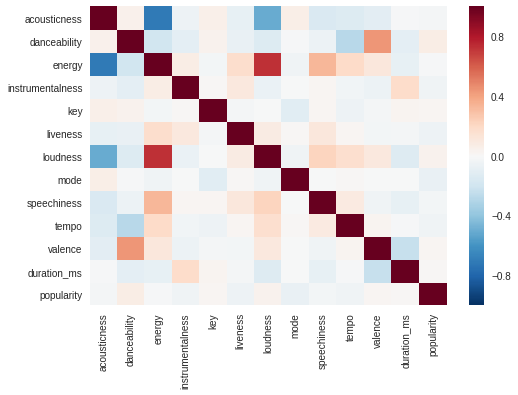

In [239]:
sns.heatmap(alldata.corr())

In [240]:
alt.Chart(alldata).mark_point().encode(
    x='danceability',
    y='valence',
    tooltip='name'
)

Chart({
  data:       acousticness  danceability  energy                      id  \
  5378      0.021800         0.541   0.703  79Mjfhh393dZdAsTvUFDR6   
  7091      0.101000         0.314   0.709  5DRyV3ql5cpXGKjYtoUuaw   
  4521      0.000472         0.531   0.905  1SrjuqOxQdkjuumN29970z   
  2752      0.349000         0.357   0.837  6op963izlXngtlIgYHEV2o   
  3532      0.025300         0.358   0.856  37CMjUAU8fL6YqZVTplZqZ   
  5731      0.000313         0.408   0.943  6sIv5esnu8C9TbLWG8lpfb   
  6072      0.092800         0.918   0.609  0CAfXk7DXMnon4gLudAp7J   
  4690      0.000032         0.503   0.967  7Gg3vweZopSn1QBEvM8YSF   
  5721      0.616000         0.589   0.456  62dzdabvxt5GndDINZWTGo   
  1222      0.002400         0.666   0.776  6rAXHPd18PZ6W8m9EectzH   
  3300      0.000220         0.632   0.909  0dgwSbMu48medMyy3DsAlG   
  3422      0.001460         0.367   0.978  4TncWhCfACwaIU8hllz8SQ   
  3077      0.000654         0.549   0.748  2KOlXagIVZQbKrrZrsKjdx   
  6241      0.039200         0.726   0.635  66hPieui6mNDQOUZsPLmxg   
  5718      0.355000         0.695   0.427  78JRorZJZH4cnSRWT2qq5f   
  2861      0.007880         0.413   0.938  5kKtznkBdVH1j2LzeuG8Sx   
  5353      0.000512         0.669   0.946  6In1MTxcgm3bi55NZsNI0O   
  3585      0.043200         0.852   0.651  5m578MgxuEC956dulprCe8   
  3070      0.000372         0.455   0.989  7G7goP3778xJ9AtdmlhSNx   
  4413      0.714000         0.439   0.569  0ZObDSV7QWyu0Zdinf61Mq   
  5934      0.001800         0.581   0.888  3o2ESAMet1zR1aASlzrIxO   
  5523      0.060000         0.589   0.903  2kPQFWoXuRz6jNsEo48Inm   
  4961      0.010200         0.635   0.944  1LToyfnrRiLfE9FAwajPLv   
  5311      0.034600         0.381   0.754  2CuKay95qBslCXvHAGDKyc   
  1129      0.006580         0.270   0.996  3u0sTmeFs1jjMEBm9wfIS1   
  5925      0.189000         0.788   0.798  05CTGhMQQuBDJ5XkNYz6f4   
  42        0.000326         0.480   0.805  6O2GvPpoqP3dP9rJjaAdtJ   
  3623      0.063100         0.567   0.970  5eUFEXgV5Sb2ohKDLYZPod   
  5467      0.000891         0.544   0.871  2mFFPUhN29U9PdGXZlR2Iu   
  6455      0.103000         0.411   0.962  0oDMQmipUDEH6ufAZo9QwL   
  ...            ...           ...     ...                     ...   
  2160      0.001500         0.514   0.975  33MkFDjrJszX5BgFoaLJg0   
  3273      0.000780         0.238   0.935  4bO90UtXyCqmvil6A4CvnA   
  6715      0.002720         0.416   0.715  4iHCodolxdaRL2rTvZNGwS   
  6044      0.031100         0.866   0.693  2WFMhUUGHMI4YY8xllNN2k   
  3088      0.001450         0.508   0.971  3zZ009FB8sc8JghwVrbLFq   
  5305      0.002500         0.541   0.975  0exunPxmEEMEGD7LeYuuhu   
  2429      0.004000         0.385   0.866  04aAxqtGp5pv12UXAg4pkq   
  4981      0.180000         0.534   0.727  5J2q3trG8im2QFuNryTGVt   
  6968      0.240000         0.414   0.664  7Hk6vSplBGJ6zK9GcGgeIa   
  3150      0.000330         0.405   0.950  2EGF4JrisrJ4D4HOdTyYEO   
  5967      0.038300         0.562   0.857  6nHqns54LRqDNjeqKDF3v8   
  4583      0.174000         0.537   0.415  16815x8pHjZuPcpzzz4Bnn   
  4915      0.001500         0.512   0.532  67yqi8Q2f82sTg7nUxIM56   
  7017      0.032600         0.340   0.987  4MnxWVZ0LGUin03tpSfdo8   
  3612      0.000319         0.499   0.951  7JQAAD9sfuTghb7NfrOHr0   
  2802      0.031800         0.451   0.868  0gfcxQRl3Q8CipxiHK5hdu   
  2470      0.285000         0.596   0.925  44NeG8aY5ciuPpWHPRlRze   
  3423      0.001160         0.472   0.984  73nWqXQgY3kC72JPkzYoJW   
  1507      0.036200         0.587   0.965  1zHlj4dQ8ZAtrayhuDDmkY   
  843       0.010700         0.569   0.931  0v9JiebCBHgxQYxPFUHtj5   
  2194      0.001110         0.522   0.957  1RutQ7SR6qzR6dwpmP8ccX   
  4551      0.011600         0.486   0.937  7JIHGWA6uT33iN2zuiakvy   
  6260      0.000182         0.516   0.942  5GKVcvTgnFYtfh25qKQtRg   
  6600      0.153000         0.587   0.713  0Fifn4lBIGM5LG18Whp1Dx   
  4597      0.000061         0.460   0.938  368ydLOy4zfhp1u76Ttxxb